## A demo for endmember selection with PaCMAP and unmixing on a single tile - including preprocessing

In [8]:
# import modules
import sys
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
from functions_EDX import *

from VCA import *
import pacmap
from annoy import AnnoyIndex
import random

### load a single tile hyperspectral dataset

In [3]:
# choose a directory (from the multi-tile map)
npz_dir = '/Volumes/Microscopy3/EDX_data/old_datasets/NPZ/'
# or 'path/to/NPZdirectory' 
file_names = os.listdir(npz_dir)
file_names = [name for name in file_names if name.endswith('npz')]

# chooe the index of the dataset within the directory
file_idx = 9

# load data
file_path = os.path.join(npz_dir,file_names[file_idx])
loaded_file = np.load(file_path)
haadf = loaded_file['haadf']
spectrum = loaded_file['spectrum'][:,:,96:]
xray_energies = loaded_file['xray_energies'][96:]
size_xy = spectrum.shape[2]

### Pre-processing

In [4]:
# Binning in the spectral dimension
n_bins = 250
start = datetime.now()
spectrum = rebin_spectrum(spectrum,n_bins)
xray_energies = rebin_energies(xray_energies,n_bins)

# Binning in spatial dimensions
size_xy = 1024
spectrum = rebin_spectrumXY(spectrum,size_xy)  
haadf = rebin_XY(haadf,size_xy)       

# check if there are empty channels
where_notempty = ~np.all(spectrum==0,axis=(0,1))
spectrum = spectrum[:,:,where_notempty]
spectral_depth = spectrum.shape[2]
spectrum_2D = np.reshape(spectrum,(size_xy*size_xy,spectral_depth))
print("%04d channels remain" % spectral_depth)

# Mean-filter
spectrum = MeanFilterCube(spectrum.astype('float32'),sigma=2, size=3)
spectrum_2D = np.reshape(spectrum,(size_xy*size_xy,spectral_depth))

# Poisson scaling (i.e. weighted PCAA
g = np.mean(spectrum,axis=2).reshape(size_xy*size_xy,1)
h = np.mean(np.mean(spectrum,axis=0),axis=0).reshape(spectral_depth,-1)
W = g@np.transpose(h)
W = np.sqrt(W) 
spectrum_2D = np.divide(spectrum_2D,W)
spectrum = np.reshape(spectrum_2D,(size_xy,size_xy,spectral_depth))
end = datetime.now()


print('Preprocessing completed in {}'.format(end - start))

0250 channels remain
Preprocessing completed in 0:00:16.123247


### Display HAADF and NPS based on pre-processed data

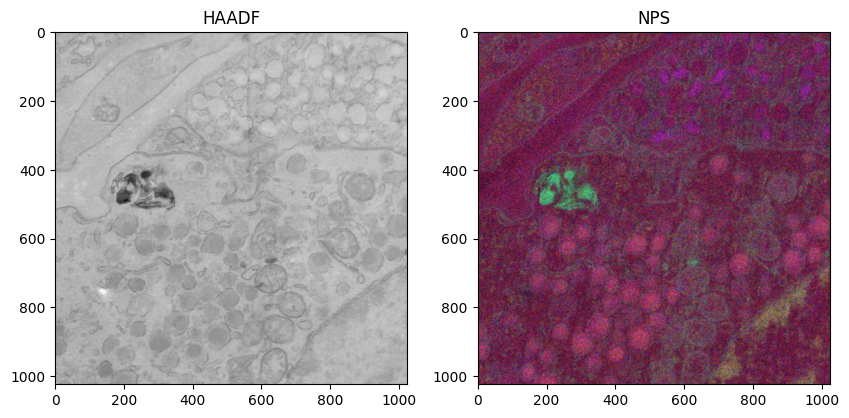

In [5]:
rgb = cv.merge([normalize8(spectrum[:,:,4]), normalize8(spectrum[:,:,25]), normalize8(spectrum[:,:,28])])
f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(haadf,cmap='gray_r')
ax[0].set_title('HAADF')
ax[1].imshow(rgb)
ax[1].set_title('NPS')
plt.show()

### Compute the extended spectrum: Gaussian Kernels with different radii around each pixel appended to the base specrum of the pixel.

In [6]:
# specify the desired radii for the kernels
radii = [1,3,5]
spectrum_ext = spectrum_plus(spectrum,radii=radii,sigma=2)
spectrum_2D_ext = np.dstack((spectrum,spectrum_ext)).reshape((-1,(len(radii)+1)*n_bins))
print(spectrum_2D_ext.shape)

(1048576, 1000)


### Overlap exclusion
- For multi-tile (mosaic) acquisitions, we exclude the overlapped area from the EDX analysis, as it is imaged twice. The function (overlap_corr) takes the index of the tile as input. If the dataset is not from a tiled acquisition, set the tile_idx as 0.

In [7]:
#  Overlap mask
overlap_mask = overlap_corr(tile_idx=0,xy_dim=size_xy,rows=6,cols=5,overlap_ratio=0.15).ravel()
non_overlap_indices = np.asarray([i for i in range(spectrum_2D.shape[0])])[~overlap_mask]

### Train PaCMAP and visualize the reduced dimensions

In [10]:
# configure PaCMAP
PACMAP_dist = 'euclidean'
MN_ratio = 0.5          #default 0.5
FP_ratio = 2.0          #default 2.0
    

# subsampling and other settings
extended = True                                 # use the extended (Gaussian kernel) spectra
p = None                        
subsample_ratio = 0.3
to_zscore = False
nTrain = int(subsample_ratio*size_xy**2)   # number of training samples


# random seed
random.seed(100)
n_sample_train = np.random.choice(non_overlap_indices,nTrain,p=p,replace=True)  

# PaCMAP
start = datetime.now()
reduction_model = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=MN_ratio, FP_ratio=FP_ratio,distance=PACMAP_dist,save_tree = True)


# set the effective spectrum for embedding
if to_zscore:
    if extended:
        spectrum_2D_eff = zscore(spectrum_2D_ext)
    else:
        spectrum_2D_eff = zscore(spectrum_2D)
else:
    if extended:
        spectrum_2D_eff = spectrum_2D_ext
    else:
        spectrum_2D_eff = spectrum_2D

# train model
reduction_model.fit(spectrum_2D_eff[n_sample_train,:])
embeddings = reduction_model.embedding_


# scaling (scaled both reduced dimensions to 0-1)
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

# elapsed time
end = datetime.now()
etime = end-start
print('Duration for training PaCMAP is: {}'.format(end - start))

Duration for training PaCMAP is: 0:03:37.923693


### Visualize the reduced dimensions

In [ ]:
%matplotlib inline 
f, ax = plt.subplots(figsize=(10,10))
sns.despine(left=True, bottom=True, right=True)

ax.set_facecolor((1, 1, 1)) 
ax.scatter(embeddings[:,0],embeddings[:,1], s=0.001,c='k') 

f.tight_layout()
plt.axis('off')
plt.show()